In [ ]:
!pip install roboflow
!pip install inference-sdk
!pip install roboflow opencv-python-headless matplotlib numpy --quiet

  Using cached roboflow-1.2.11-py3-none-any.whl.metadata (9.7 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached roboflow-1.2.11-py3-none-any.whl (89 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
  Att

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os, glob, cv2, numpy as np
from PIL import Image, ImageOps
from inference_sdk import InferenceHTTPClient
import tempfile

CLIENT = InferenceHTTPClient(api_url="https://serverless.roboflow.com",
                             api_key="wecTpR1c9b1cDima8utR")

def preprocess_fix_orientation(src_path, max_long_side=1280):
    """EXIF-fix and resize once. Return temp path and image as np.array(BGR)."""
    im = Image.open(src_path)
    im = ImageOps.exif_transpose(im)                     # fix rotation
    w, h = im.size
    scale = min(1.0, max_long_side / float(max(w, h)))   # downscale if large
    if scale < 1.0:
        im = im.resize((int(round(w*scale)), int(round(h*scale))), Image.BILINEAR)
    tmp = tempfile.NamedTemporaryFile(suffix=".jpg", delete=False)
    im.save(tmp.name, quality=95)
    arr = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
    return tmp.name, arr

def crop_from_roboflow_consistent(src_path, model_id="chessboard-detection-x5kxd/1", pad_frac=0.05):
    # 1) Canonicalize the image once
    tmp_path, img = preprocess_fix_orientation(src_path, max_long_side=1280)
    H, W = img.shape[:2]

    # 2) Infer on the SAME file we will crop
    res = CLIENT.infer(tmp_path, model_id=model_id)
    preds = res.get("predictions", [])
    if not preds:
        print("no detection:", os.path.basename(src_path))
        os.unlink(tmp_path); return None

    det = max(preds, key=lambda p: p.get("confidence", 0))
    # Roboflow returns coords in the input it processed (our tmp image). No scaling needed.
    x, y, w, h = float(det["x"]), float(det["y"]), float(det["width"]), float(det["height"])

    # 3) Padding and crop on the SAME image
    x1 = max(int(round(x - w/2 - pad_frac*w)), 0)
    y1 = max(int(round(y - h/2 - pad_frac*h)), 0)
    x2 = min(int(round(x + w/2 + pad_frac*w)), W)
    y2 = min(int(round(y + h/2 + pad_frac*h)), H)

    crop = img[y1:y2, x1:x2].copy()
    os.unlink(tmp_path)
    if crop.size == 0:
        print("empty crop:", os.path.basename(src_path))
        return None
    return crop

# ---- Batch (keeps variable sizes; no warp/resize) ----
input_dir = "/content/input_images"
output_dir = "/content/output_images"
os.makedirs(output_dir, exist_ok=True)

paths = []
for ext in ("*.jpg","*.jpeg","*.png","*.bmp"):
    paths += glob.glob(os.path.join(input_dir, ext))
print(f"Found {len(paths)} images in {input_dir}")

for p in paths:
    crop = crop_from_roboflow_consistent(p, pad_frac=0.01)
    if crop is None:
        print("[skip]", p); continue
    out = os.path.join(output_dir, os.path.splitext(os.path.basename(p))[0] + "_cropped.jpg")
    cv2.imwrite(out, crop)
    print("[saved]", out, crop.shape[::-1][1:], "HxW")

Found 4 images in /content/input_images
[saved] /content/output_images/cosmos_camera_024_cropped.jpg (555, 539) HxW
[saved] /content/output_images/cosmos_camera_025_cropped.jpg (581, 568) HxW
[saved] /content/output_images/cosmos_camera_023_cropped.jpg (484, 476) HxW
[saved] /content/output_images/cosmos_camera_022_cropped.jpg (550, 532) HxW


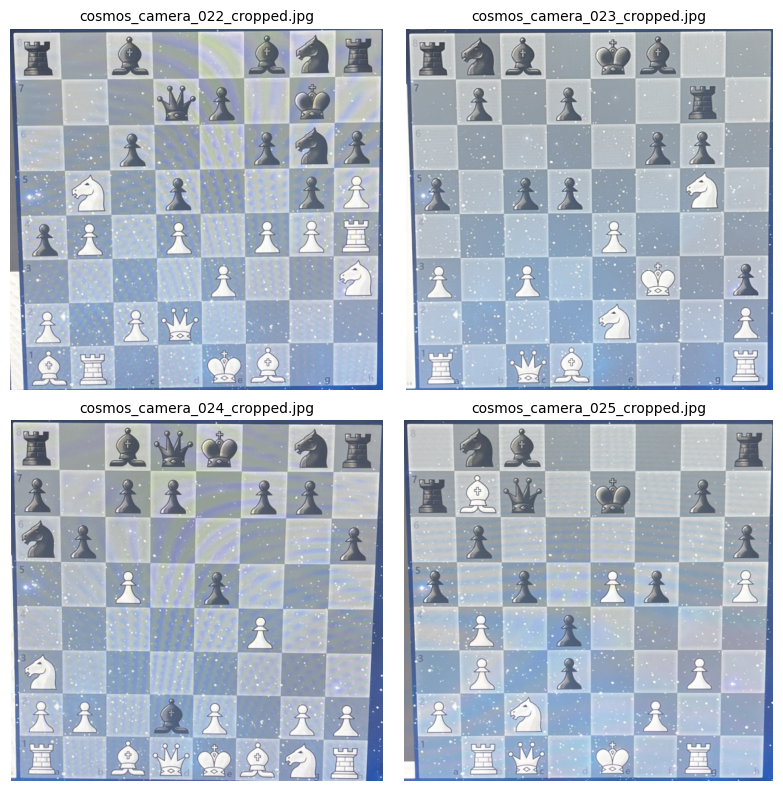

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

output_dir = '/content/output_images'
image_files = [f for f in os.listdir(output_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
image_files.sort() # Sort to display in a consistent order

n_images = len(image_files)
if n_images == 0:
    print("No images found in the output directory to display.")
else:
    # Determine grid size (simple approach: square or close to square)
    n_cols = int(np.ceil(np.sqrt(n_images)))
    n_rows = int(np.ceil(n_images / n_cols))

    plt.figure(figsize=(n_cols * 4, n_rows * 4)) # Adjust figure size as needed

    for i, image_file in enumerate(image_files):
        img_path = os.path.join(output_dir, image_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB for matplotlib
            plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(img)
            plt.title(image_file, fontsize=10)
            plt.axis('off')
        else:
            print(f"Could not read image: {image_file}")

    plt.tight_layout()
    plt.show()

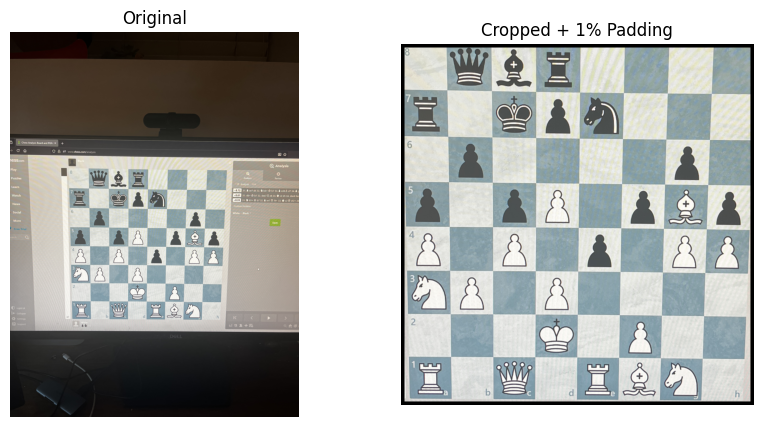

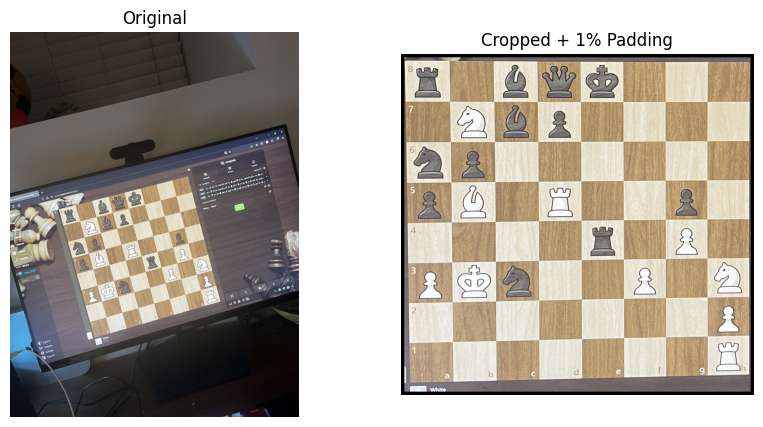

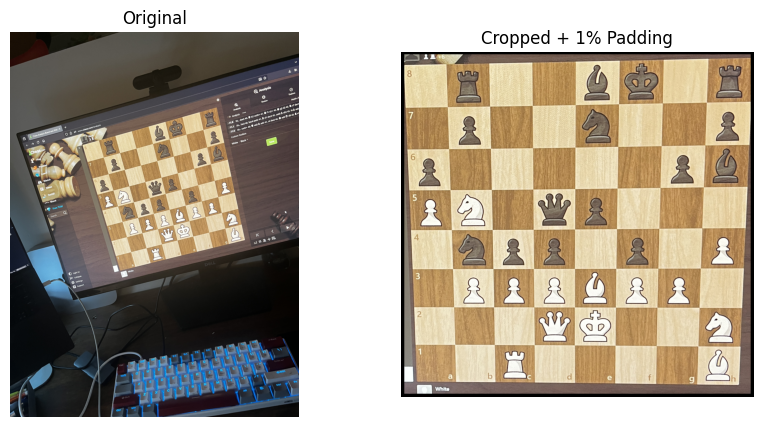

In [ ]:
import os, cv2, json, numpy as np, matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient

# --- Setup Roboflow Inference Client ---
CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="wecTpR1c9b1cDima8utR"
)

input_dir = "/content/input_images"
output_dir = "/content/output_images"
os.makedirs(output_dir, exist_ok=True)

def crop_chessboard(img, points, pad_frac=0.01):
    """Crop using polygon points with padding; handle non-rectangular masks."""
    pts = np.array([[p["x"], p["y"]] for p in points], np.int32)
    hull = cv2.convexHull(pts)

    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int32(box)

    w, h = int(rect[1][0]), int(rect[1][1])
    if w == 0 or h == 0:
        return None

    src = np.float32(box)
    dst = np.float32([[0,0],[w-1,0],[w-1,h-1],[0,h-1]])
    M = cv2.getPerspectiveTransform(src, dst)
    warp = cv2.warpPerspective(img, M, (w, h))

    pad = int(max(w, h) * pad_frac)
    warp = cv2.copyMakeBorder(warp, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[0,0,0])
    return warp

# --- Process each image ---
for fname in os.listdir(input_dir):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img_path = os.path.join(input_dir, fname)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Cannot read {fname}")
        continue

    result = CLIENT.infer(img_path, model_id="chessboard-1hk4y/3")
    preds = result.get("predictions", [])

    if not preds:
        print(f"No chessboard detected in {fname}")
        continue

    crop = crop_chessboard(img, preds[0]["points"])
    if crop is None:
        print(f"Failed to crop {fname}")
        continue

    out_path = os.path.join(output_dir, fname)
    cv2.imwrite(out_path, crop)

    # --- Visualization ---
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.title("Cropped + 1% Padding")
    plt.axis("off")
    plt.show()

In [ ]:
rm -rf /content/input_images/*


In [ ]:
rm -rf /content/output_images/*